In [24]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata as ad 

from scipy.stats import spearmanr

import xgboost as xgb 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn import svm

from tqdm import tqdm 
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path

from config import FDIR_EXTERNAL, FDIR_RAW, FDIR_PROCESSED, FDIR_INTEMEDIATE

In [25]:
fdir_raw = FDIR_RAW
fdir_intermediate = FDIR_INTEMEDIATE
fdir_processed = FDIR_PROCESSED / 'sex'
fdir_external = FDIR_EXTERNAL

ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'age'
organ = 'CAGE.HEART'

sex = 'M'
sex = 'F'


In [26]:
adata = ad.read_h5ad(fdir_processed / f'{organ.upper()}.preprocessed.sex.h5ad')
adata = adata[adata.obs['age'].notna()]

adata.var_names = "tr_" + adata.var_names

adata_male = adata[adata.obs['sex'] == "M"]
adata_female = adata[adata.obs['sex'] == "F"]
# adata_both = adata.copy()


In [27]:
rhos_male = []
pvalues_male = []
rhos_female = []
pvalues_female = []

rhos = []
pvalues = []


for i in tqdm(range(adata_male.n_vars)):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(adata_male.X[:, i], adata_male.obs['age'].values)
    rhos_male.append(rho)
    pvalues_male.append(pvalue)
    
# for i in tqdm(range(adata_female.n_vars)):
    rho, pvalue = spearmanr(adata_female.X[:, i], adata_female.obs['age'].values)
    rhos_female.append(rho)
    pvalues_female.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)
rhos_male = np.array(rhos_male)
rhos_female = np.array(rhos_female)

rhos_male_nonan_ids = np.argwhere(~np.isnan(rhos_male)).ravel()
rhos_female_nonan_ids = np.argwhere(~np.isnan(rhos_female)).ravel()


for i in tqdm(range(adata.n_vars)):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(adata.X[:, i], adata.obs['age'].values)
    rhos.append(rho)
    pvalues.append(pvalue)
    
rhos = np.array(rhos)
rhos_nonan_ids  = np.argwhere(~np.isnan(rhos)).ravel()

  0%|          | 18/75263 [00:00<24:11, 51.82it/s]/tmp/ipykernel_89544/2038681497.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(adata_male.X[:, i], adata_male.obs['age'].values)
/tmp/ipykernel_89544/2038681497.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(adata_female.X[:, i], adata_female.obs['age'].values)
  0%|          | 0/75263 [00:00<?, ?it/s]/tmp/ipykernel_89544/2038681497.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(adata.X[:, i], adata.obs['age'].values)
100%|██████████| 75263/75263 [00:25<00:00, 2995.93it/s]


In [28]:
adata_male.varm['rho'] = rhos_male
adata_female.varm['rho'] = rhos_female
adata.varm['rho'] = np.array(rhos)

adata_male.varm['pvalue'] = np.array(pvalues_male)
adata_female.varm['pvalue'] = np.array(pvalues_female)
adata.varm['pvalue'] = np.array(pvalues)

adata_male_nona = adata_male[:, rhos_male_nonan_ids].copy()
adata_female_nona = adata_female[:, rhos_female_nonan_ids].copy()
adata_nona = adata[:, rhos_nonan_ids].copy()

/tmp/ipykernel_89544/3340560788.py:1: ImplicitModificationWarning: Setting element `.varm['rho']` of view, initializing view as actual.
  adata_male.varm['rho'] = rhos_male
/tmp/ipykernel_89544/3340560788.py:2: ImplicitModificationWarning: Setting element `.varm['rho']` of view, initializing view as actual.
  adata_female.varm['rho'] = rhos_female


/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


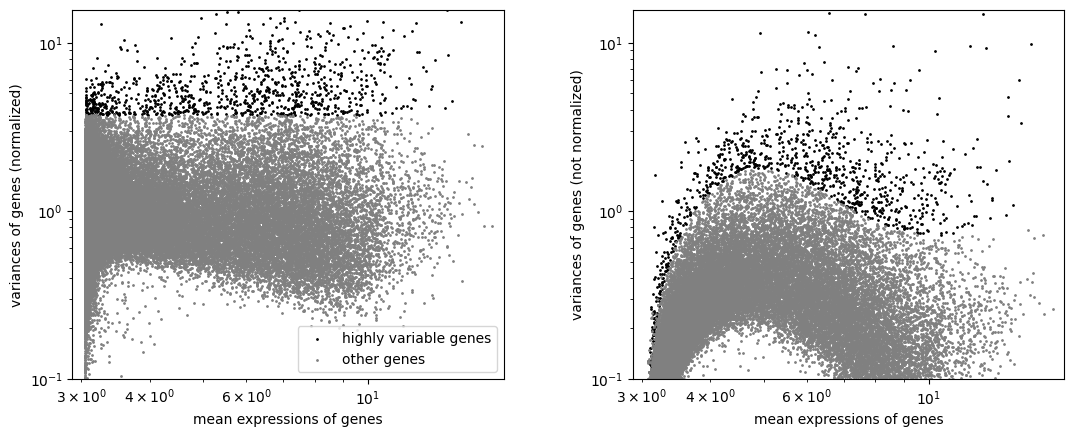

/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


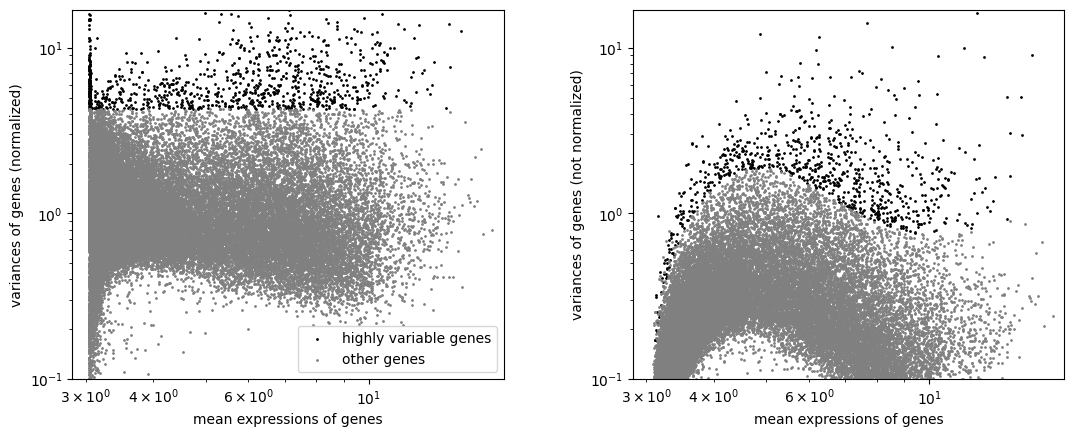

/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


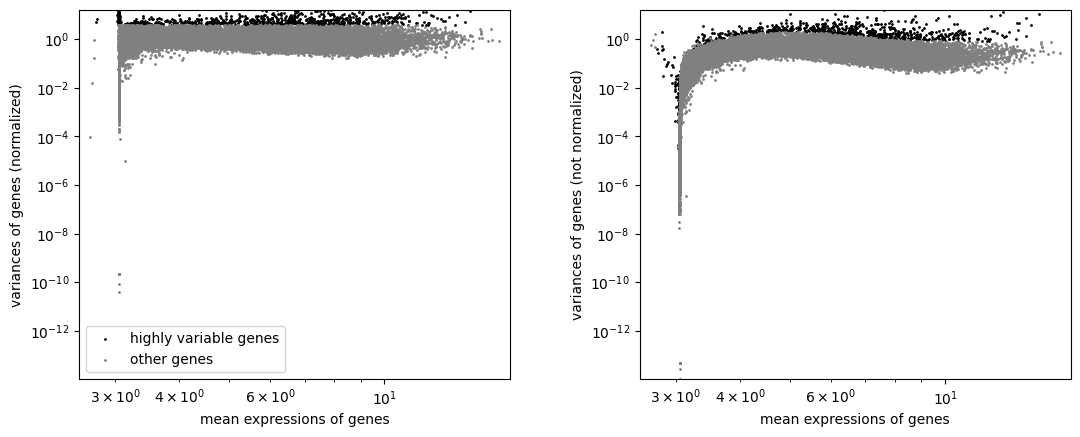

In [37]:
# flavor = 'cell_ranger'
flavor = 'seurat_v3_paper'
flavor = 'seurat_v3'
# flavor = 'seurat'

n_top_genes = 1000

sc.pp.highly_variable_genes(adata_nona, n_top_genes=n_top_genes, flavor=flavor)
sc.pl.highly_variable_genes(adata_nona,log=True)

sc.pp.highly_variable_genes(adata_male_nona, n_top_genes=n_top_genes, flavor=flavor)
sc.pl.highly_variable_genes(adata_male_nona,log=True)

sc.pp.highly_variable_genes(adata_female_nona, n_top_genes=n_top_genes, flavor=flavor)
sc.pl.highly_variable_genes(adata_female_nona,log=True)

# # experimental 
# sc.experimental.pp.highly_variable_genes(adata_nona, n_top_genes=100,)
# sc.pl.highly_variable_genes(adata_nona)

# sc.experimental.pp.highly_variable_genes(adata_male_nona, n_top_genes=100)
# sc.pl.highly_variable_genes(adata_male_nona)

# sc.experimental.pp.highly_variable_genes(adata_female_nona, n_top_genes=100)
# sc.pl.highly_variable_genes(adata_female_nona)





In [38]:
sc.tl.pca(adata_male_nona, n_comps=80)
sc.tl.pca(adata_female_nona, n_comps=80)
sc.tl.pca(adata_nona, n_comps=80)
    

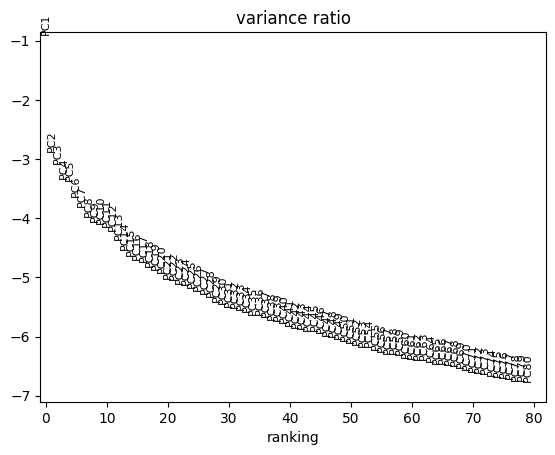

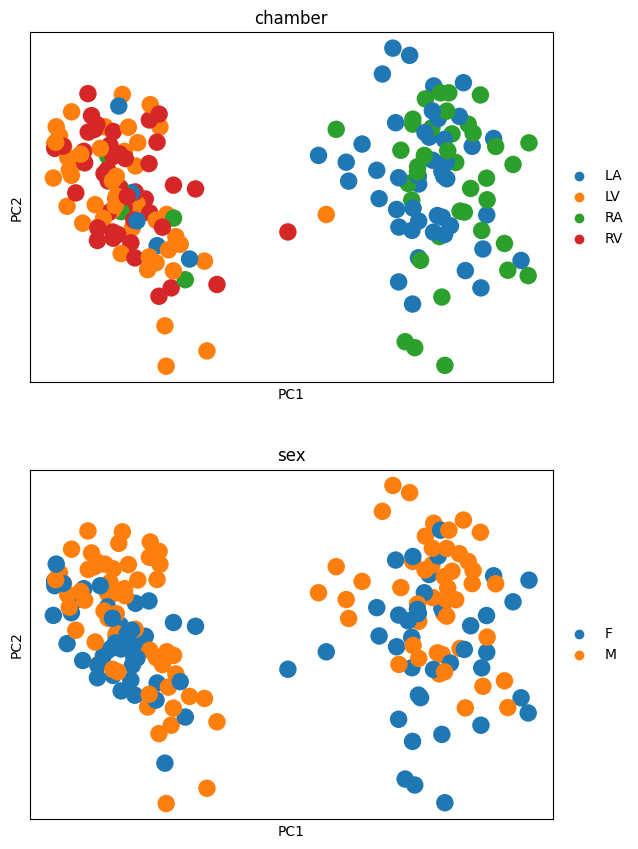

In [39]:
sc.pl.pca_variance_ratio(adata_nona, n_pcs=81, log=True)

sc.pl.pca(
    adata_nona,
    color=["chamber", "sex"],
    dimensions=[(0, 1), (0, 1)],
    ncols=1,
    # size=2,
    # color='chamber'
)

In [40]:

# if flavor == 'seurat':
#     transcripts_all = adata_nona.var['dispersions_norm'].loc[adata_nona.var['highly_variable']].sort_values()[::-1].index
#     transcripts_m = adata_male_nona.var['dispersions_norm'].loc[adata_male_nona.var['highly_variable']].sort_values()[::-1].index
#     transcripts_f = adata_female_nona.var['dispersions_norm'].loc[adata_female_nona.var['highly_variable']].sort_values()[::-1].index

# else:
        
#     # transcripts = adata_nona.var['highly_variable_rank'][adata_nona.var['highly_variable']].sort_values()[::-1].index
#     transcripts_all = adata_nona.var['highly_variable_rank'][adata_nona.var['highly_variable']].sort_values().index
#     transcripts_m = adata_male_nona.var['highly_variable_rank'][adata_male_nona.var['highly_variable']].sort_values().index
#     transcripts_f = adata_female_nona.var['highly_variable_rank'][adata_female_nona.var['highly_variable']].sort_values().index
# transcripts_all

#     # 0 - max var, 99 - smalest variance


In [41]:

# transcripts_all = adata_nona.var['highly_variable_rank'][adata_nona.var['highly_variable']].sort_values().index
# transcripts_m = adata_male_nona.var['highly_variable_rank'][adata_male_nona.var['highly_variable']].sort_values().index
# transcripts_f = adata_female_nona.var['highly_variable_rank'][adata_female_nona.var['highly_variable']].sort_values().index


if flavor == 'seurat':
    transcripts_all = adata_nona.var['dispersions_norm'].loc[adata_nona.var['highly_variable']].sort_values()[::-1].index
    transcripts_m = adata_male_nona.var['dispersions_norm'].loc[adata_male_nona.var['highly_variable']].sort_values()[::-1].index
    transcripts_f = adata_female_nona.var['dispersions_norm'].loc[adata_female_nona.var['highly_variable']].sort_values()[::-1].index

else:
        
    transcripts_all = adata_nona.var['highly_variable_rank'][adata_nona.var['highly_variable']].sort_values().index
    transcripts_m = adata_male_nona.var['highly_variable_rank'][adata_male_nona.var['highly_variable']].sort_values().index
    transcripts_f = adata_female_nona.var['highly_variable_rank'][adata_female_nona.var['highly_variable']].sort_values().index

datasets = {
    'Both': adata_nona,
    'Male': adata_male_nona,
    'Female': adata_female_nona
}

transcripts_dict = {
    "Both": transcripts_all,
    "Male": transcripts_m,
    "Female": transcripts_f        
}

cv = StratifiedKFold(n_splits=5)


for key, dataset in datasets.items(): 
    transcripts = transcripts_dict[key]
    
    ranks = np.zeros(n_top_genes)
    X = dataset[:, transcripts].X
    y = dataset.obs['age'].values
    
    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]
        
        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test
        
        model = xgb.XGBRegressor(n_estimators=300, max_depth=4)
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        # if i > 1:
        #     break
        ranks += model.feature_importances_ 
        
    transcripts_dict[key] = transcripts[ranks.argsort()[::-1][:100]]


0it [00:00, ?it/s]/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:05,  1.10s/it]
0it [00:00, ?it/s]/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:01,  2.53it/s]
0it [00:00, ?it/s]/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:01,  4.15it/s]


In [42]:
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import r2_score


datasets = {
    'Both': adata_nona,
    'Male': adata_male_nona,
    'Female': adata_female_nona
}

# transcripts_dict = {
#     "ALL": transcripts_all,
#     "Male": transcripts_m,
#     "Female": transcripts_f        
# }

scores = {
    'r2': {},
    'RMSE': {}
} 

for key, dataset in datasets.items(): 

    rmses = []
    r2_scores = []
    
    transcripts = transcripts_dict[key]

    # for n_features in tqdm(range(1, 100)):
    for n_features in tqdm(range(1, 30)):

        cv = StratifiedKFold(n_splits=5)
        
        X = dataset[:, transcripts[:n_features]].X
        y = dataset.obs['age'].values

        preds = []
        vals  = []
        
        for i, (train, val) in enumerate(cv.split(X, y)):
            X_train = X[train]
            y_train = y[train]
            X_test = X[val]
            y_test = y[val]
            
            X_train_ = X_train
            y_train_ = y_train
            X_val = X_test
            y_val = y_test
            
            model = xgb.XGBRegressor(n_estimators=300, max_depth=4)
            # model = svm.SVR(kernel='linear')
            # model = Ridge()
            
            
            model.fit(X_train_, y_train_)
            pred = model.predict(X_val)
            
            preds.extend(pred)
            vals.extend(y_val)
            
        rmses.append(RMSE(np.ravel(preds), np.ravel(vals)))
        r2_scores.append(r2_score(np.ravel(vals), np.ravel(preds)))

    scores['RMSE'][key] = rmses
    scores['r2'][key] = r2_scores

    # print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
    # print("R2: ", r2_score(np.ravel(vals), np.ravel(preds)))


  0%|          | 0/29 [00:00<?, ?it/s]/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
  3%|▎         | 1/29 [00:00<00:17,  1.63it/s]/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
  7%|▋         | 2/29 [00:00<00:12,  2.11it/s]/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
 10%|█         | 3/29 [00:01<00:13,  1.99it/s]/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, whic

In [43]:
scores['RMSE']

{'Both': [11.893506903208843,
  10.65553845956799,
  9.026021447527631,
  8.989142605153788,
  8.381136122049307,
  7.116138717060018,
  6.696289415733375,
  6.642394103573035,
  6.80034615745926,
  6.207695283395801,
  6.101943918771268,
  6.002326842888773,
  6.029431422538387,
  5.882420186667117,
  5.95737087548738,
  6.046636743965615,
  6.054308393844376,
  5.910166789363082,
  6.051147045853504,
  6.025760996866641,
  6.036128193975564,
  6.037482966045373,
  5.832817153047772,
  5.785919156436952,
  5.7488082172066965,
  5.9410494764167305,
  5.931590526358105,
  6.032428989911125,
  5.9239440278367885],
 'Male': [11.183983794856209,
  8.647516414345885,
  6.793013657510217,
  6.377047573247533,
  5.378757040633697,
  5.678984078457342,
  5.059444523920062,
  4.7322082191077905,
  4.802359598906556,
  4.593509305710471,
  4.306634120342357,
  4.291672067409445,
  4.292954768822626,
  4.125746752277718,
  3.91954543369118,
  3.948210313204301,
  3.94494324596823,
  4.03019120324

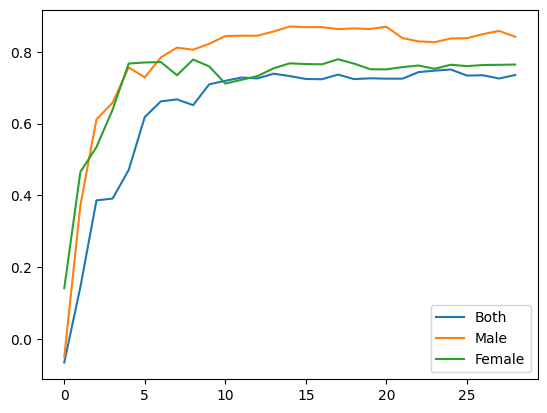

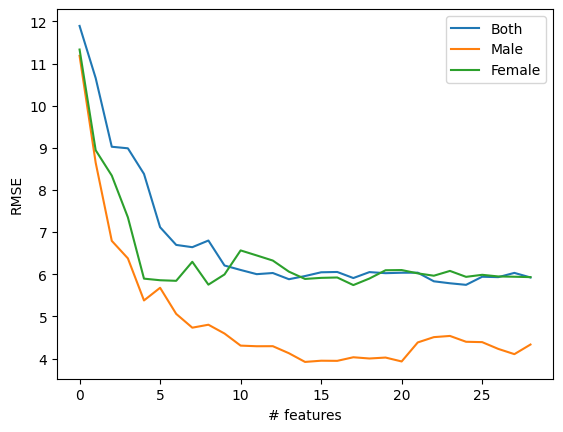

In [44]:
plt.figure()
for key, value in scores['r2'].items():
    plt.plot(value, label=key)
plt.legend()
plt.show()

plt.figure()
for key, value in scores['RMSE'].items():
    plt.plot(value, label=key)
plt.xlabel("# features")
plt.ylabel("RMSE")
plt.legend()
plt.show()


In [45]:
scores['RMSE']['Both'][14], scores['RMSE']['Male'][14], scores['RMSE']['Female'][14]

(5.95737087548738, 3.91954543369118, 5.889029876105161)

In [46]:
n_features = 14

results = {}

for key, dataset in datasets.items(): 

    rmses = []
    r2_scores = []
    cv = StratifiedKFold(n_splits=5)
    
    transcripts = transcripts_dict[key]

    X = dataset[:, transcripts[:n_features]].X
    y = dataset.obs['age'].values

    preds = np.zeros(len(y))
    vals  = np.zeros(len(y))

    for i, (train, val) in enumerate(cv.split(X, y)):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]
        
        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test
        
        model = xgb.XGBRegressor(n_estimators=300, max_depth=4)
        # model = svm.SVR(kernel='linear')
        # model = Ridge()
        
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        preds[val] = pred
        vals[val] = y_val
        
        # preds.extend(pred)
        # vals.extend(y_val)
        
    results[key] = {}
    results[key]['preds'] = preds
    results[key]['vals'] = vals

/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


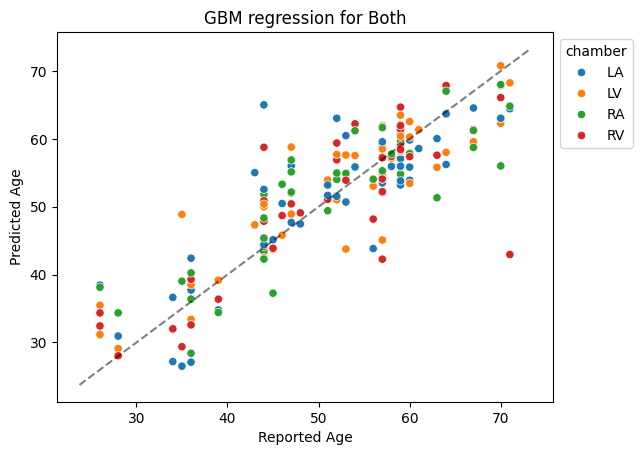

5.882420186667117


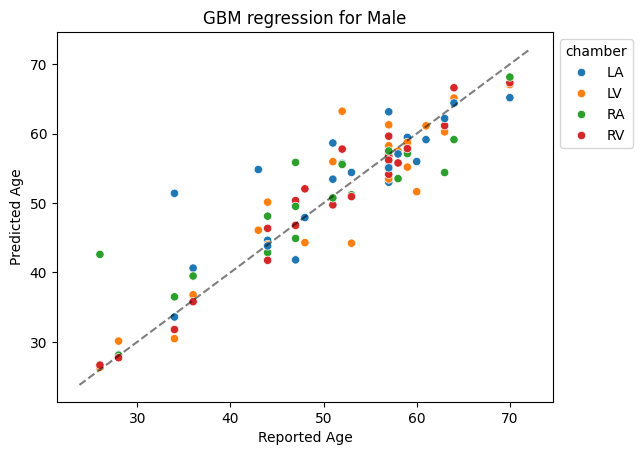

4.125746752277718


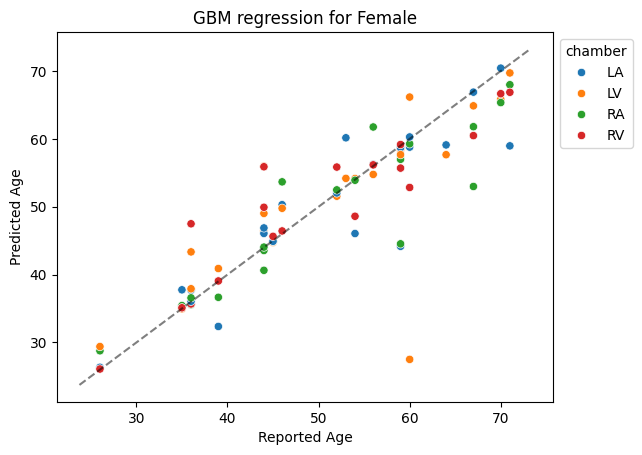

6.061811471800575


In [ ]:



for key, val in results.items():
   
    g = sns.scatterplot(
        x=np.array(val['vals']).ravel(), 
        y=np.array(val['preds']).ravel(), 
        # hue=datasets[key].obs['chamber']
        )
    g.set_title(f"GBM regression for {key}")
    g.set_ylabel("Predicted Age")
    g.set_xlabel("Reported Age")

    lims = [
        np.min([g.get_xlim(), g.get_ylim()]),  # min of both axes
        np.max([g.get_xlim(), g.get_ylim()]),  # max of both axes
    ]

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    g.plot(lims, lims, '--', color='k', alpha=0.5)
    
    plt.show()
    
    print(RMSE(np.ravel(val['vals']), np.ravel(val['preds'])))


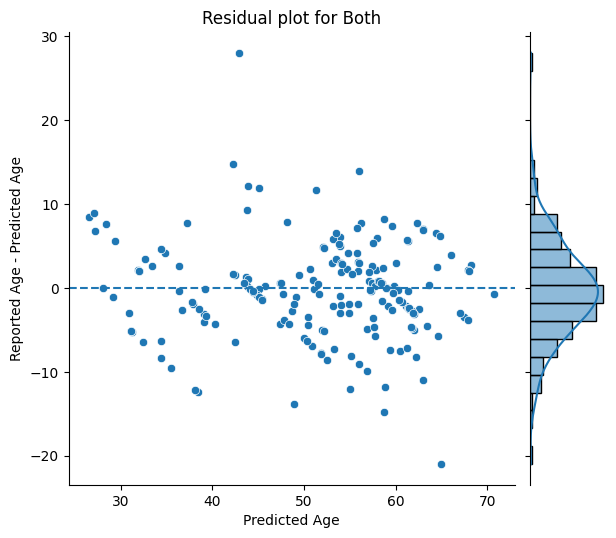

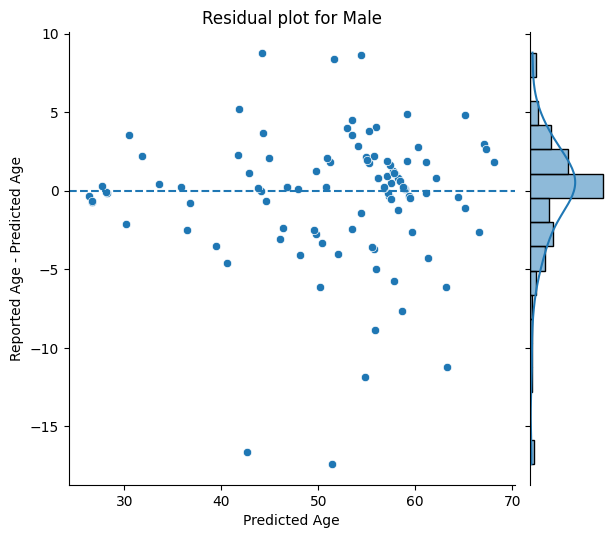

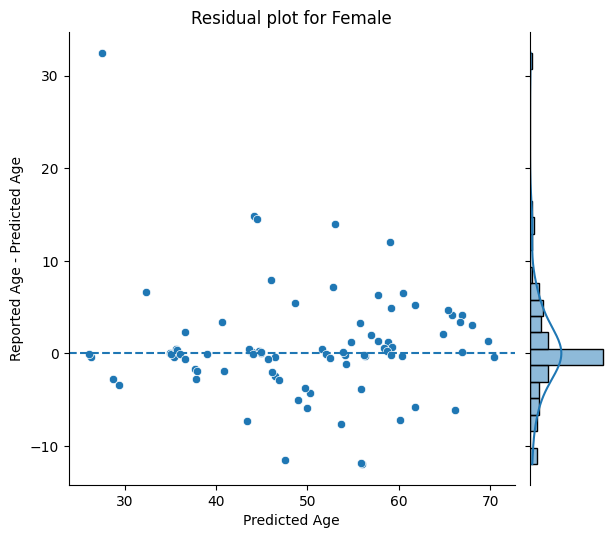

In [112]:
# RESIDUAL PLOT
for key, val in results.items():


    g = sns.JointGrid()
# x, y = penguins["bill_length_mm"], penguins["bill_depth_mm"]
    sns.scatterplot(x=np.array(val['preds']).ravel(), 
                    y=np.array(val['vals']).ravel() - np.array(val['preds']).ravel(),  
                    ax=g.ax_joint)
    # g.plot([70, 30], [0,0], '--', color='k', alpha=0.5)
    sns.histplot(y=np.array(val['vals']).ravel() - np.array(val['preds']).ravel(), ax=g.ax_marg_y, kde=True)
    g.ax_joint.axhline(ls='--')
    g.ax_joint.set_title(f"Residual plot for {key}")
    g.ax_joint.set_ylabel("Reported Age - Predicted Age")
    g.ax_joint.set_xlabel("Predicted Age")
    
    g.ax_marg_x.remove()

    # g = sns.jointplot(
    #     x=np.array(val['preds']).ravel(), 
    #     y=np.array(val['vals']).ravel() - np.array(val['preds']).ravel(), 
    #     # hue=datasets[key].obs['chamber'],
    #     kind='reg',
    #     )
    # g.set_title(f"Residual plot for {key}")
    # g.set_ylabel("Reported Age - Predicted Age")
    # g.set_xlabel("Predicted Age")


    plt.show()

In [86]:
X

ArrayView([[ 6.33067372,  3.0286629 ,  8.90399556, ..., 10.42048136,
             4.67704188,  5.26642811],
           [ 6.49497694,  3.0286629 ,  8.48323118, ..., 11.8300512 ,
             6.1522033 ,  4.97787561],
           [ 6.49247584,  3.0286629 ,  8.77678423, ..., 10.31936663,
             6.83331065,  5.36381994],
           ...,
           [ 4.09431072,  3.44709149,  6.10579777, ...,  6.28485521,
             5.119103  ,  2.84973839],
           [ 4.10397592,  3.00621011, 10.31143652, ..., 10.60480008,
             5.88967387,  5.63784828],
           [ 6.23445238,  3.00621011,  9.44447888, ..., 10.98365483,
             8.43336152,  2.9084719 ]])

<Axes: >

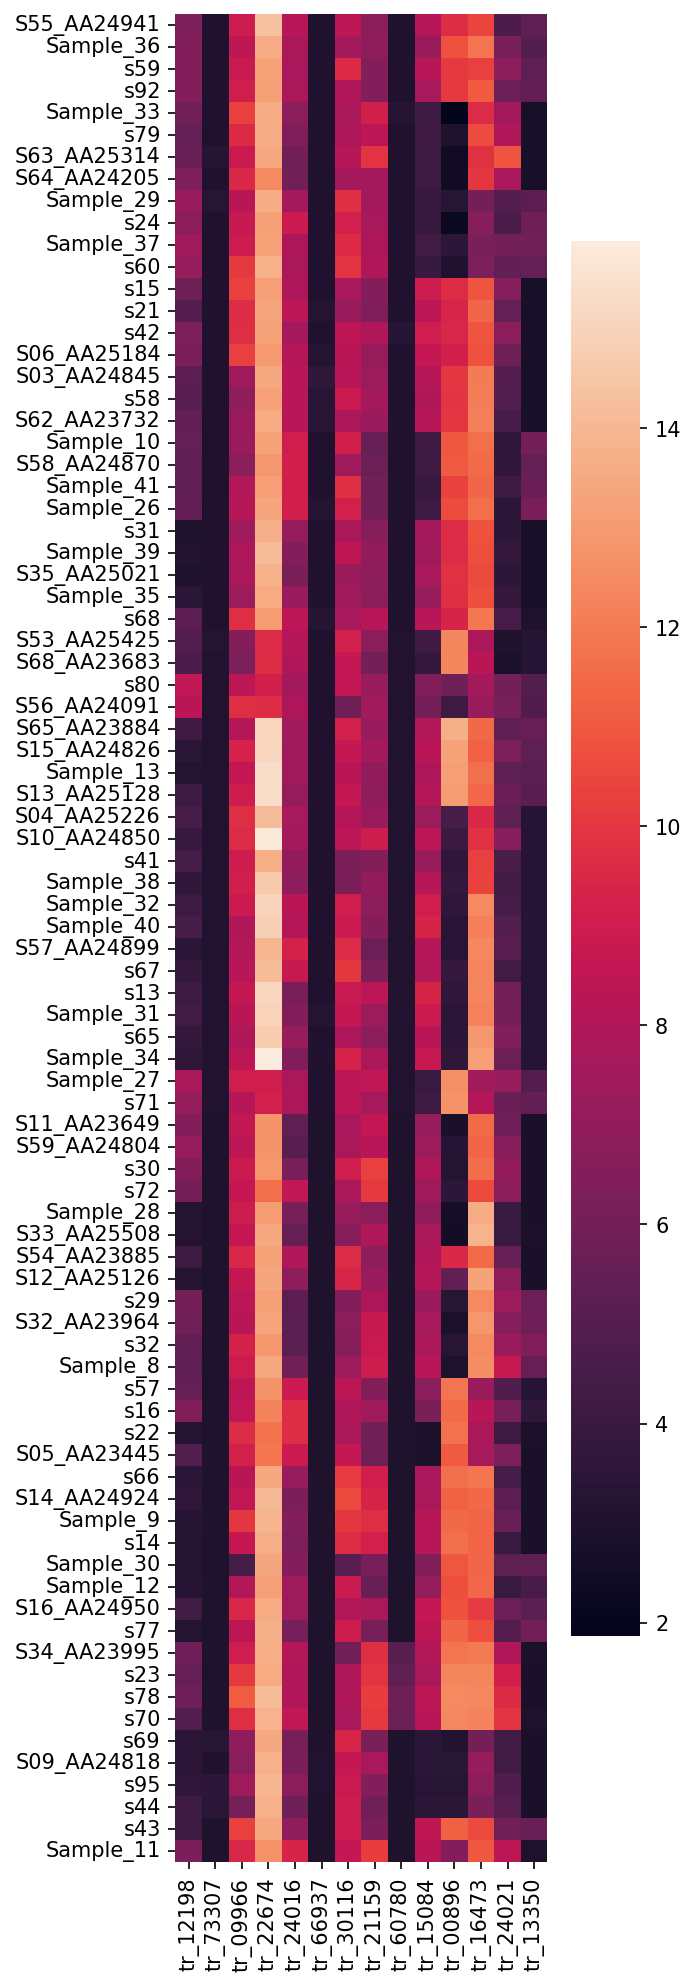

In [ ]:
# datasets
# np.argwhere((np.array(results['Female']['preds']) < 30) & (np.array(results['Female']['vals']) > 50))

key = "Female"
transcripts = transcripts_dict[key]

plt.figure(figsize=(4,16), dpi=150)
sns.heatmap(datasets[key][:, transcripts[:14]].to_df(),
            yticklabels=datasets[key].obs.index[np.argsort((results[key]['preds'] - results[key]['vals'])**2)],
            )


# np.array(val['vals']).ravel()
# np.array(val['preds']).ravel()


In [ ]:
top_transcripts = {}
n_features = 30
for key, dataset in datasets.items(): 

    rmses = []
    r2_scores = []
    cv = StratifiedKFold(n_splits=5)
    
    transcripts = transcripts_dict[key]
    top_transcripts[key] = transcripts[:n_features]
top_transcripts

{'Both': Index(['tr_23546', 'tr_14063', 'tr_09529', 'tr_29252', 'tr_25032', 'tr_22236',
        'tr_02555', 'tr_22674', 'tr_12508', 'tr_13122', 'tr_06027', 'tr_13518',
        'tr_26981', 'tr_11100', 'tr_01249', 'tr_08253', 'tr_25318', 'tr_14235',
        'tr_01970', 'tr_31174', 'tr_10954', 'tr_13738', 'tr_24016', 'tr_23819',
        'tr_15578', 'tr_15084', 'tr_30215', 'tr_29132', 'tr_20148', 'tr_13441'],
       dtype='object'),
 'Male': Index(['tr_23546', 'tr_24521', 'tr_25670', 'tr_66944', 'tr_22236', 'tr_18970',
        'tr_06027', 'tr_16473', 'tr_15397', 'tr_09529', 'tr_03564', 'tr_11089',
        'tr_30751', 'tr_11245', 'tr_12508', 'tr_25122', 'tr_31075', 'tr_21335',
        'tr_23225', 'tr_00354', 'tr_44269', 'tr_12459', 'tr_31174', 'tr_21160',
        'tr_16946', 'tr_23057', 'tr_10220', 'tr_29086', 'tr_08127', 'tr_25904'],
       dtype='object'),
 'Female': Index(['tr_12198', 'tr_73307', 'tr_09966', 'tr_22674', 'tr_24016', 'tr_66937',
        'tr_30116', 'tr_21159', 'tr_60780', 

In [ ]:
adata.var.loc[top_transcripts['Both']].to_csv("/home/ar3/Documents/PYTHON/RNASeqAnalysis/reports/CAGE.HEART.age.Both.csv")
adata.var.loc[top_transcripts['Male']].to_csv("/home/ar3/Documents/PYTHON/RNASeqAnalysis/reports/CAGE.HEART.age.Male.csv")
adata.var.loc[top_transcripts['Female']].to_csv("/home/ar3/Documents/PYTHON/RNASeqAnalysis/reports/CAGE.HEART.age.Female.csv")

In [ ]:
top_transcripts['Both'].values

array(['tr_23546', 'tr_14063', 'tr_09529', 'tr_29252', 'tr_25032',
       'tr_22236', 'tr_02555', 'tr_22674', 'tr_12508', 'tr_13122',
       'tr_06027', 'tr_13518', 'tr_26981', 'tr_11100', 'tr_01249',
       'tr_08253', 'tr_25318', 'tr_14235', 'tr_01970', 'tr_31174',
       'tr_10954', 'tr_13738', 'tr_24016', 'tr_23819', 'tr_15578',
       'tr_15084', 'tr_30215', 'tr_29132', 'tr_20148', 'tr_13441'],
      dtype=object)

['Female'] : 
{'tr_24306', 'tr_08926', 'tr_24021', 'tr_12525', 'tr_12198', 'tr_04127', 'tr_48593', 'tr_00896', 'tr_11259', 'tr_12460', 'tr_00994', 'tr_13350', 'tr_66937', 'tr_18938', 'tr_04234', 'tr_05342', 'tr_16349', 'tr_60780', 'tr_09966', 'tr_17611', 'tr_21159', 'tr_73307', 'tr_20686', 'tr_30116', 'tr_21155'}
['Both'] : 
{'tr_20148', 'tr_08253', 'tr_02555', 'tr_14235', 'tr_30215', 'tr_26981', 'tr_11100', 'tr_01249', 'tr_25032', 'tr_15578', 'tr_14063', 'tr_13518', 'tr_29132', 'tr_10954', 'tr_13441', 'tr_29252', 'tr_25318', 'tr_13738', 'tr_01970', 'tr_23819'}
['Male'] : 
{'tr_03564', 'tr_00354', 'tr_31075', 'tr_25122', 'tr_21160', 'tr_08127', 'tr_29086', 'tr_25904', 'tr_11089', 'tr_25670', 'tr_12459', 'tr_30751', 'tr_21335', 'tr_66944', 'tr_23225', 'tr_24521', 'tr_18970', 'tr_15397', 'tr_44269', 'tr_10220', 'tr_23057', 'tr_16946', 'tr_11245'}
['Both' 'Female'] : 
{'tr_15084', 'tr_13122', 'tr_24016', 'tr_22674'}
['Male' 'Female'] : 
{'tr_16473'}
['Both' 'Male'] : 
{'tr_31174', 'tr_222

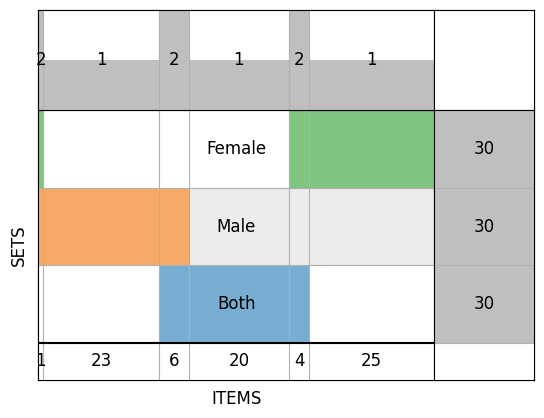

In [ ]:
from supervenn import supervenn

test_dict = {
    "Both": set(top_transcripts['Both'].values),
    "Male": set(top_transcripts['Male'].values),
    "Female": set(top_transcripts['Female'].values),
}

g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        chunks_ordering='minimize gaps',
        )


membership = []
memb_data = []

for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])

    membership.append((np.array(list(test_dict.keys()))[list(el)]).tolist())
    memb_data.append(len(g.chunks[el]))

/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

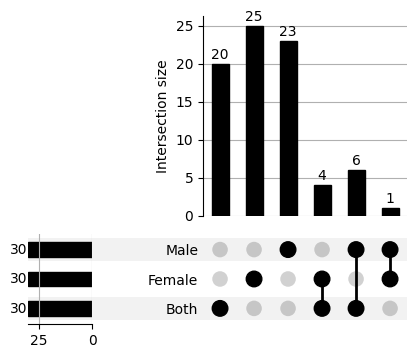

In [ ]:
from upsetplot import from_memberships, plot


example = from_memberships(membership, data=memb_data)
plot(example, show_counts=True)


/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To re

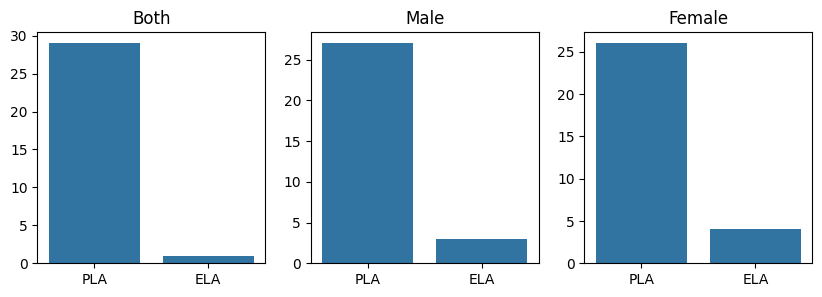

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(10,3))
sns.barplot(x=['PLA', "ELA"], 
            y=[np.sum(adata.var.loc[top_transcripts['Both']][['class']] == 'PLA').item(), np.sum(adata.var.loc[top_transcripts['Both']][['class']] == 'ELA').item()],
            ax=axs[0])
axs[0].set_title('Both')
sns.barplot(x=['PLA', "ELA"], 
            y=[np.sum(adata.var.loc[top_transcripts['Male']][['class']] == 'PLA').item(), np.sum(adata.var.loc[top_transcripts['Male']][['class']] == 'ELA').item()],
            ax=axs[1])
axs[1].set_title('Male')
sns.barplot(x=['PLA', "ELA"], y=[np.sum(adata.var.loc[top_transcripts['Female']][['class']] == 'PLA').item(), np.sum(adata.var.loc[top_transcripts['Female']][['class']] == 'ELA').item()],
            ax=axs[2])
axs[2].set_title('Female')
plt.show()

# adata.var.loc[top_transcripts['Male']]
# adata.var.loc[top_transcripts['Female']]

In [ ]:
np.sum(adata.var.loc[top_transcripts['Both']][['class']] == 'PLA').item()

/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


29